# Generate model waveform

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


In [2]:
# Display basic info about calibration runs
scsearch( catalog=pwca_catalog, verbose=True );

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found verbose (=True) keyword.
## Found 40 possibly degenerate simulations:
[0001][hogshead] q8precessing: 1chi0.80-p-q8.00	(q8a08t120dP2_r03_T_96_360)
[0002][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t60D_dPm1)
[0003][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t90dPm1D_T_96_384)
[0004][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t120dPp1_T_96_360)
[0005][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t90dP0_T_96_360)
[0006][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th150)
[0007][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th120)
[0008][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th90)
[0009][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th60)
[0010][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th30)
[0011][hogshead] q8: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)
[0012][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t30dPm5p5dRm4

In [183]:
datadir = '/Users/book/KOALA/puck/ll/data/version2/'

# Load and unpuack physical parameter space
raw_domain = loadtxt(datadir+'fit_intial_binary_parameters.txt')
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2 = raw_domain.T

In [184]:
print theta

[ 90.23457257  30.1531826   60.08914582 120.18771004  60.00670195
  30.10186595 120.26069567 150.10438183  60.17893667  30.02875566
  60.26586529  30.3052075  120.36327626  90.30516687 150.04890558
  30.09594769  90.61992502 150.147703    90.39686679  90.19633645
 120.51284607  30.19207204  60.35353054 150.13512649  60.5383777
 120.17579734  90.11681092  30.00444796 120.05907042 150.28579912
 150.01303479  60.04074768 120.08624817  30.03953075  90.04104912
  90.07059875 150.21287455 120.03920685  60.14887559 150.06306673]


In [ ]:

#
def pwca_waveform( f, m1, m2, theta, chi1, chi2, chi_p ):
    '''
    DESCRIPTION
    ---
    Calculate waveform for BBH coprecessing merger-ringdown given inputs described below
    
    USAGE
    ---
    fd_waveform_array = pwca_waveform( f, m1, m2, chi1, chi2, chi_p )
    
    f,       frequency array of desired values; frequencies are geometric: M*f_hz with M=1
    m1,      geometric mass of larger component, m1+m2=1
    m2,      geometric mass of smaller component, m1+m2=1
    theta,   angle in 
    chi1,    spin along initial L of larger component
    chi2,    spin along initial L of smaller component
    chi_p    precessing spin as defined in eqn 3.4 of https://arxiv.org/pdf/1408.1810.pdf (here, postive.physics.calc_chi_p)
    '''
    
    # Import usefuls
    from pwca import template_amp_mrd,template_dphi_mrd
    
    # Generate template functions
    template_amp  = template_amp_mrd(  m1, m2, chi1, chi2, chi_p )
    template_dphi = template_dphi_mrd( m1, m2, chi1, chi2, chi_p )
    
    #
    mu1,mu2,mu3,mu4,nu4,nu5,nu6 = generate_model_params(theta,eta,chi_eff,chi_p)
    


(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibr

NameError: global name 'array' is not defined

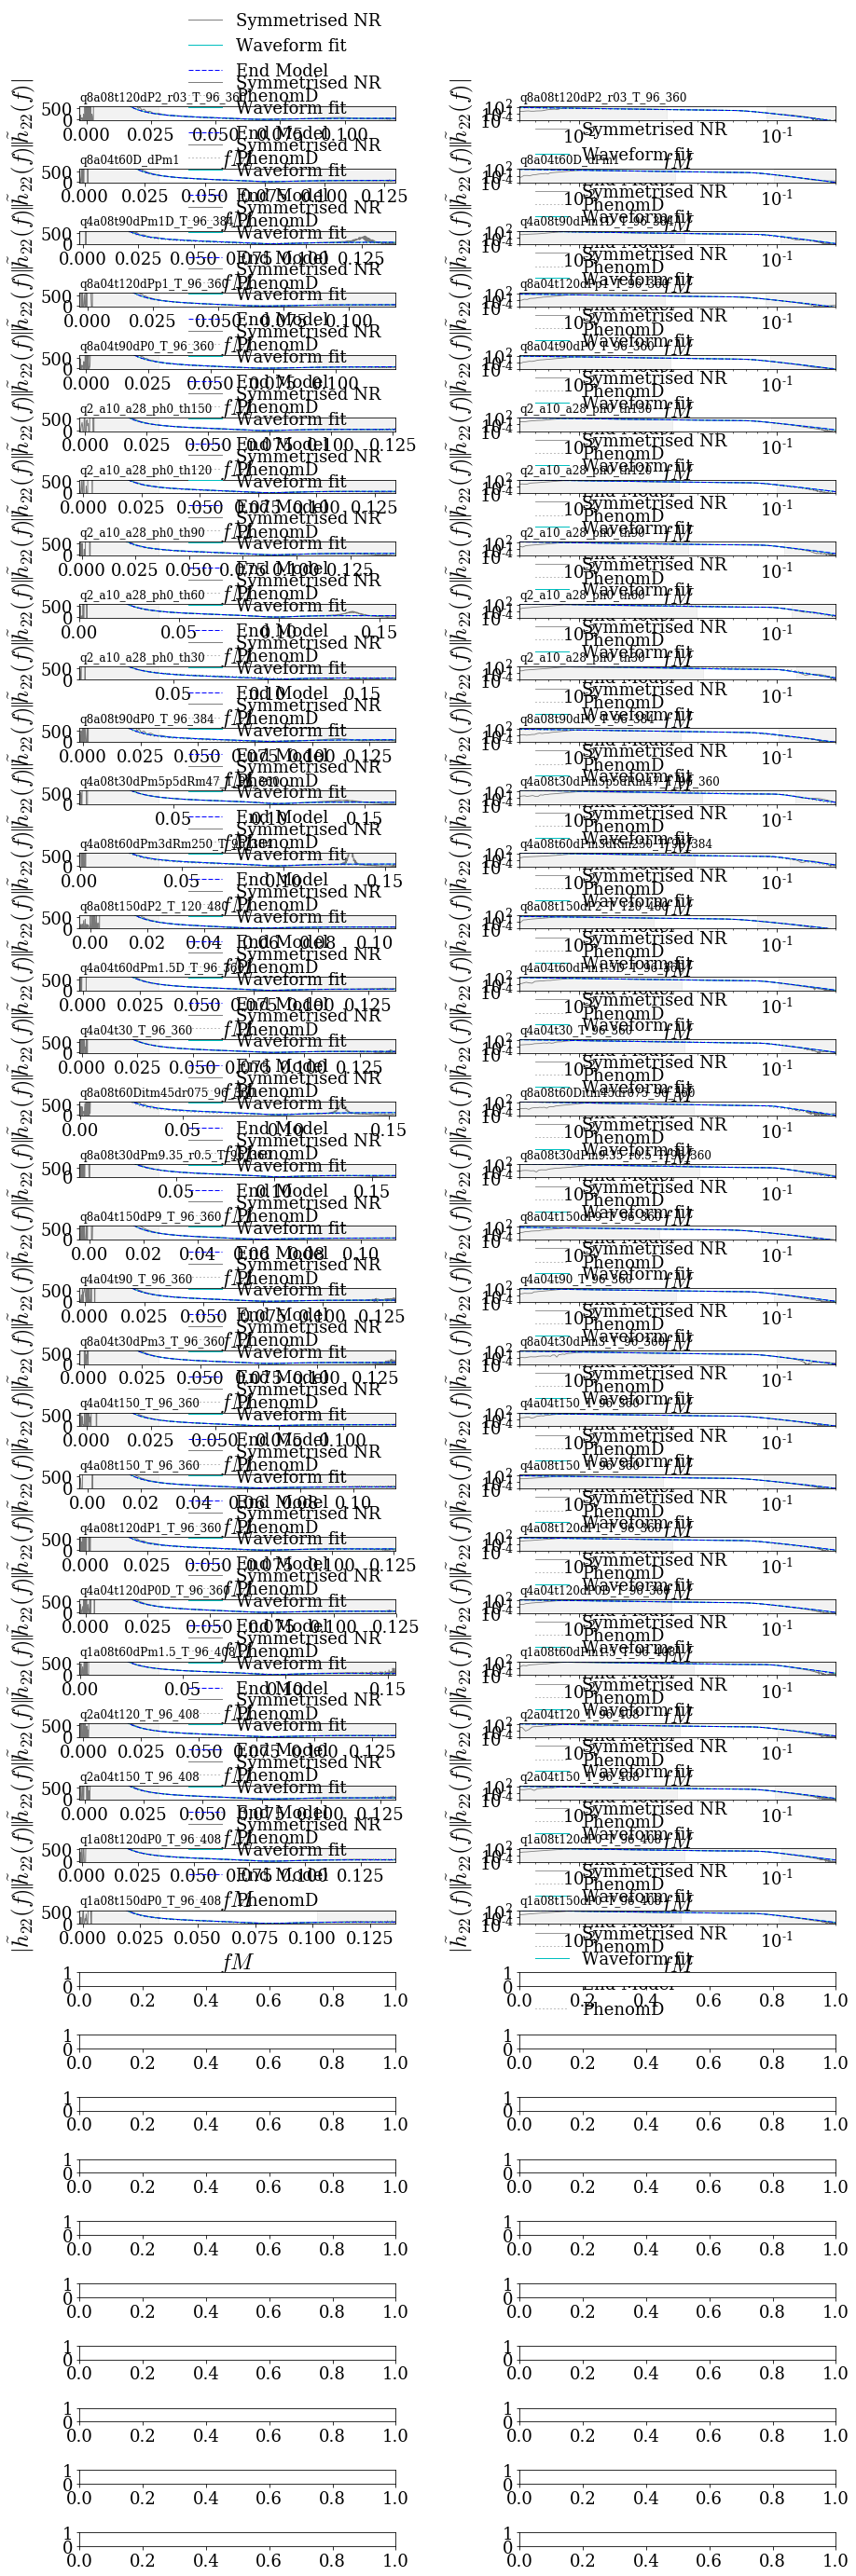

In [171]:

# Preliminaries 
# ---

# Define data location
datadir = '/Users/book/KOALA/puck/ll/data/version2/'

# Load select waveforms
files = glob( datadir+'q*.txt' )
simnames = [ f_.split('/')[-1].split('.t')[0] for f_ in files ]

# Setup plot
# ---
nrow = len(pwca_catalog)
ncol = 2
fig,ax = subplots( nrow, ncol, figsize=3*figaspect(nrow*0.618/8) )
ax = ax.flatten()

#
tight_layout(1,2,10)
lw = 2

# Plot diagnostics for all calibration cases
ax_id = 0
for a in pwca_catalog:


    # Find index corresponding to chosen case
    k = simnames.index( a.simname )
    # Load data for this case
    raw_data = loadtxt(files[k]).T
    data,_,fmin,fmax,fknot = determine_data_fitting_region(raw_data)


    # Load and unpuack OPTIMAL physical parameter space -- dphi
    dphi_range = loadtxt(datadir+'fit_opt_dphase_parameters.txt')
    opt_nu4,opt_nu5,opt_nu6 = dphi_range[k,:]
    # Load and unpuack OPTIMAL physical parameter space -- amp
    amp_range = loadtxt(datadir+'fit_opt_amplitude_parameters.txt')
    opt_mu1, opt_mu2, opt_mu3, opt_mu4 = amp_range[k,:]

    # extract useful params from scentry object
    theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2 = select_scenty_metadata(a)
    # generate model parameters 
    mu1,mu2,mu3,mu4,nu4,nu5,nu6 = generate_model_params(theta,eta,chi_eff,chi_p)

    # generate template functions
    template_amp  = template_amp_mrd(  m1, m2, chi1, chi2, chi_p )
    template_dphi = template_dphi_mrd( m1, m2, chi1, chi2, chi_p )

    # Load and unpuack physical parameter space
    raw_domain = loadtxt(datadir+'fit_intial_binary_parameters.txt')
    param_test_quantity = sum(raw_domain[k,:]-array([theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2]))==0
    if param_test_quantity:
        alert(bold(green('CHECK PASSED: '))+'Generated physical parameters are identical to calibration ones.')
    else:
        error(bold(red('CHECK PASSED: '))+'Generated physical parameters are not identical to calibration ones.')

    #
    raw_f,raw_amp_td,raw_amp_fd,raw_dphi_td,raw_dphi_fd = raw_data
    adjusted_raw_dphi_td = raw_dphi_td-min( raw_dphi_td[ (raw_f>=fmin) & (raw_f<=fmax)  ])
    f,amp_td,amp_fd,dphi_td,dphi_fd = data.T

    #
    raw_positive_mask = raw_f>0
    raw_fp = raw_f[raw_positive_mask]

    #
    phenomd_dphi   = template_dphi( raw_fp )
    opt_model_dphi = template_dphi( raw_fp, opt_nu4, opt_nu5, opt_nu6 )
    model_dphi     = template_dphi( raw_fp, nu4, nu5, nu6 )

    # Prepare amplitude data
    scale_factor = raw_fp ** (-7.0/6.0)
    phenomd_amp   = exp( template_amp( raw_fp ) ) * scale_factor
    opt_model_amp = exp( template_amp( raw_fp, opt_mu1, opt_mu2, opt_mu3, opt_mu4 ) ) * scale_factor
    model_amp     = exp( template_amp( raw_fp, mu1, mu2, mu3, mu4 ) ) * scale_factor




In [180]:
test = lambda x1,x2,x3: x1*x2*x3
test2 = lambda x1,*k: sqrt(test(x1,*k))

In [182]:
test2( 1,2,3 )**2

5.999999999999999